In [1]:
import numpy as np
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import cv2
from pathlib import Path
from ultralytics import YOLO
import os
os.environ['USE_TORCH'] = '1'
from doctr.models import ocr_predictor
import pandas as pd
import numpy as np
from doctr.models import detection_predictor
import torch
import onnxruntime as ort

/home/reshetnikov/miniconda3/envs/mmyolo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


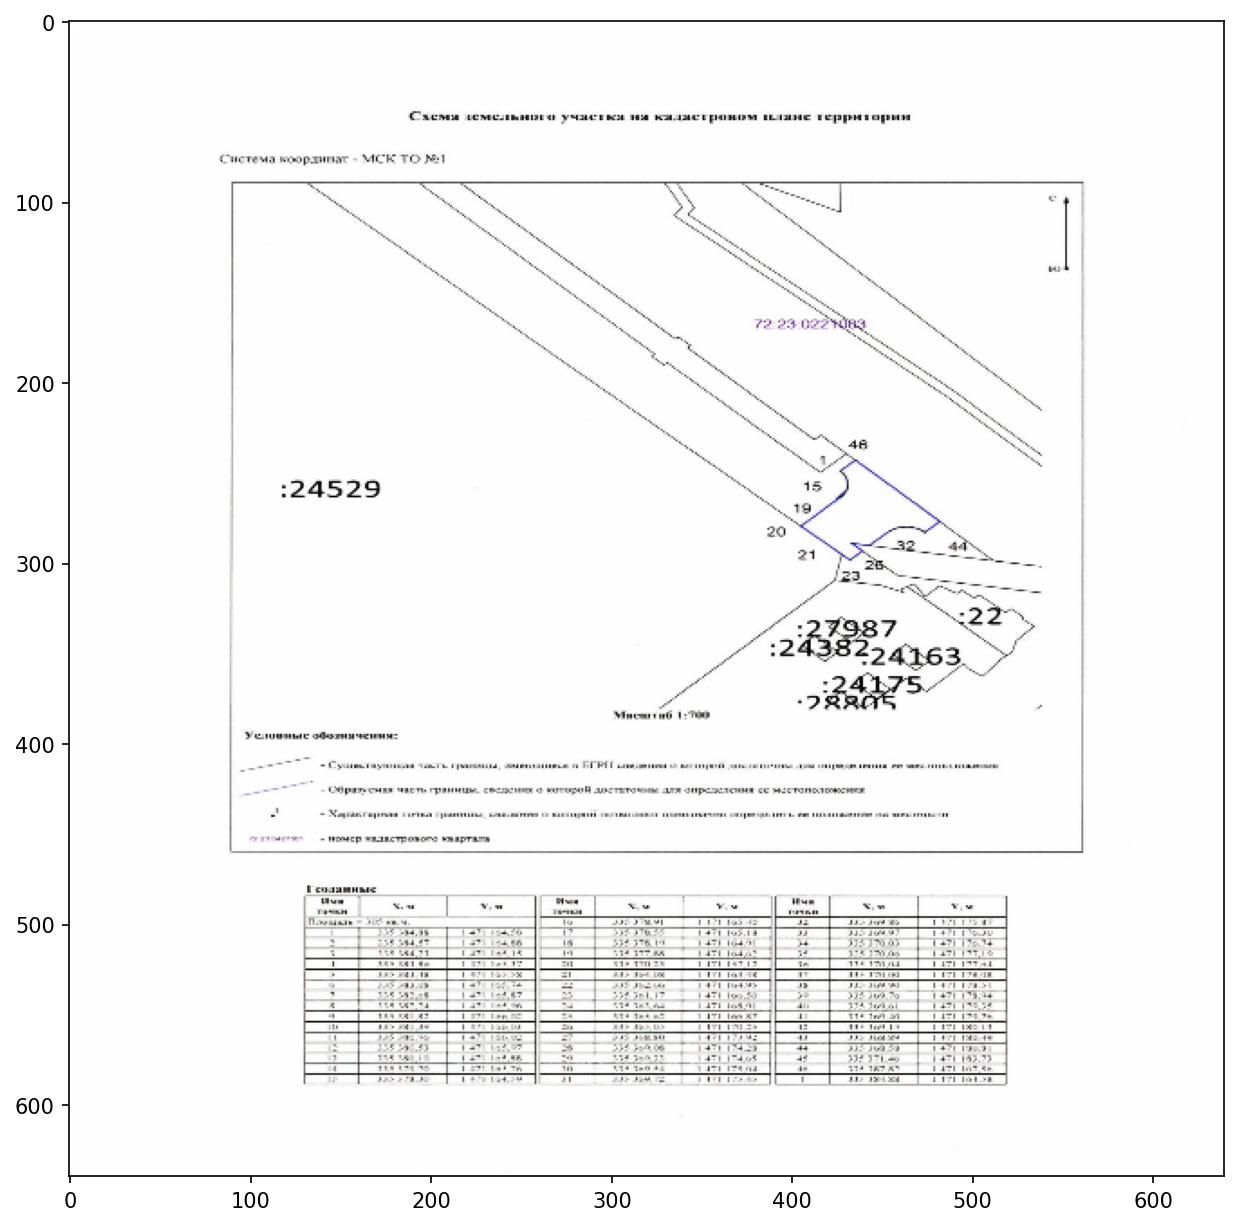

In [2]:
img = cv2.imread('../dataset/val/202309180001_page_4.jpg')
img = cv2.resize(img, (640,640))
fig = plt.figure(dpi = 150, figsize = (10,10))
plt.imshow(img)


0: 736x736 5 tables, 11.7ms
Speed: 8.0ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 736)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9136, 0.8837, 0.7139, 0.4367, 0.3844], device='cuda:0')
data: tensor([[3.9910e+02, 4.9543e+02, 5.2171e+02, 5.8994e+02, 9.1357e-01, 0.0000e+00],
        [1.3041e+02, 5.0055e+02, 2.5407e+02, 5.9040e+02, 8.8369e-01, 0.0000e+00],
        [2.6195e+02, 4.9560e+02, 3.9042e+02, 5.8964e+02, 7.1388e-01, 0.0000e+00],
        [1.6385e+02, 4.9987e+02, 2.8782e+02, 5.8985e+02, 4.3670e-01, 0.0000e+00],
        [2.9705e+02, 4.9580e+02, 4.1128e+02, 5.8962e+02, 3.8441e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([5, 6])
xywh: tensor([[460.4079, 542.6847, 122.6138,  94.5063],
        [192.2400, 545.4749, 123.6593,  89.8412],
        [326.1828, 542.6195, 128.4745,  94.0334],
        [225.8338, 544.8627, 

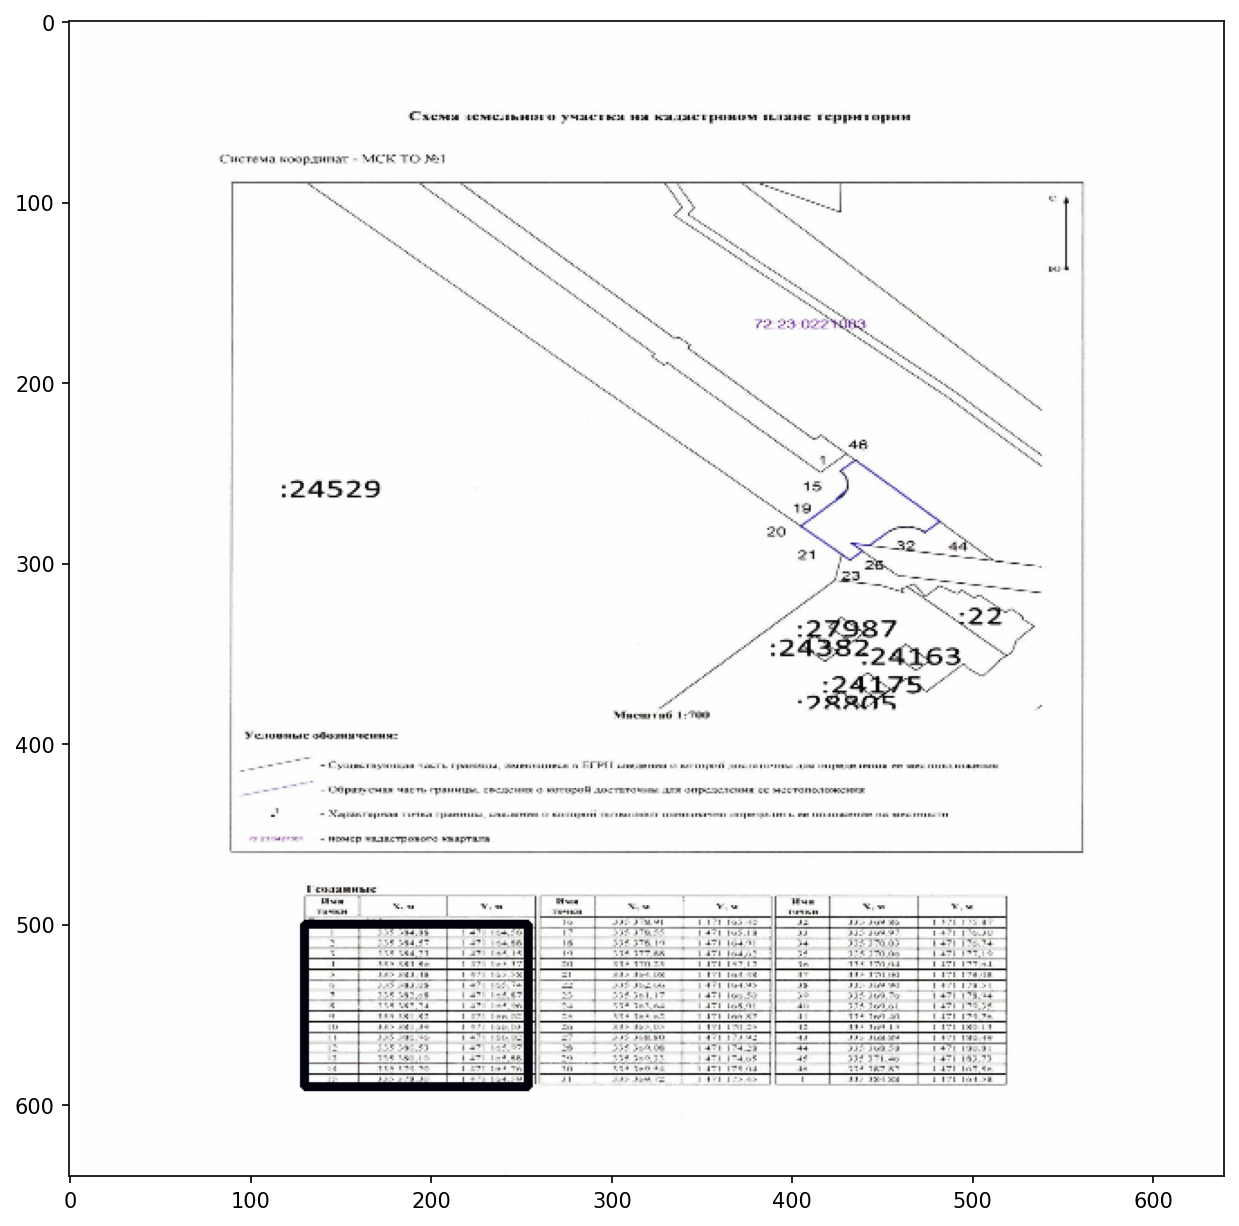

In [4]:
model = YOLO('./runs/detect/train3/weights/best.pt')

pred = model.predict(img, classes = [0])

print(pred[0].boxes)
x1,y1, x2, y2 = pred[0].boxes[1].xyxy.detach().cpu().numpy()[0]    
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
print(x1, y1, x2, y2)

fig = plt.figure(dpi = 150, figsize = (10,10))
img = cv2.rectangle(img,(int(x1), int(y1)),(int(x2), int(y2)), (1,2,12), thickness = 3)
plt.imshow(img)

In [5]:
pred = model.predict(img, classes = [0])


0: 736x736 4 tables, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 736)


In [461]:
file.name

'231027057.pdf'

In [463]:
import fitz
from PIL import Image

model = YOLO('./runs/detect/train3/weights/best.pt')



for file in list(Path("/storage/reshetnikov/sber_table/notebook/results/bad_table/").glob("*.pdf")):
    doc = fitz.open(file)  # open document
    images = []
    dpi = 200  # choose desired dpi here
    zoom = dpi / 72  # zoom factor, standard: 72 dpi
    magnify = fitz.Matrix(zoom, zoom)  
    for page in doc:
        pix = page.get_pixmap(matrix=magnify)  # render page to an image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img = np.array(img)
        pred = model.predict(img, classes = [0])
        if len(pred[0].boxes) == 0:
            continue
        if pred[0].boxes[0].conf>0.5:
            x1,y1, x2, y2 = pred[0].boxes[0].xyxy.detach().cpu().numpy()[0]    
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.imwrite(f"./results/bad_table/{file.stem}.jpg", img)
 


0: 736x544 2 tables, 10.8ms
Speed: 4.2ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 544)

0: 544x736 2 tables, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 736)

0: 736x544 4 tables, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 544)

0: 736x544 6 tables, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 544)

0: 544x736 2 tables, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 table, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 table, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 736)

0: 736x544 (no detections), 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 

In [453]:
for f in Path('../dataset/val/').glob("*.jpg"):
    img = cv2.imread(str(f))
    p = model.predict(img)
    if len(p[0].boxes) == 0:
        continue
    if p[0].boxes[0].conf>0.5:
        x1,y1, x2, y2 = p[0].boxes[0].xyxy.detach().cpu().numpy()[0]    
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        table = img[y1:y2,x1:x2,:]
        print(table.shape,  x1,y1, x2, y2 )
        try:
            cv2.imwrite(f"../dataset/table/{f.name}", img)
        except:
            print("Oшибка")

AttributeError: 'InferenceSession' object has no attribute 'predict'

In [5]:
!pwd

/storage/reshetnikov/sber_table/notebook


In [ ]:
from pdf2image import convert_from_path, convert_from_bytes
images = convert_from_path(open('/storage/reshetnikov/sber_table/dataset/tabl/230915035/202309150001.pdf', 'rb').read())
for i in range(len(images)):
    images[i].save(f'./temp/{pdf_file.stem}_page_{i}.jpg', 'JPEG')

## OCR

In [3]:
images = list(Path("../dataset/all_table/").rglob("*"))
IMAGE_EXTENTIONS = (".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".gif", ".webp")
print(images[:5])

[PosixPath('../dataset/all_table/Схема_общ_page_1.jpg'), PosixPath('../dataset/all_table/202310040001_page_1.jpg'), PosixPath('../dataset/all_table/схема границ публичного сервитута_page_0.jpg'), PosixPath('../dataset/all_table/202309220001_page_1.jpg'), PosixPath('../dataset/all_table/4.jpg')]


In [8]:
model = YOLO('./runs/detect/train3/weights/best.pt')
model = YOLO('./runs/detect/train3/weights/best.pt')

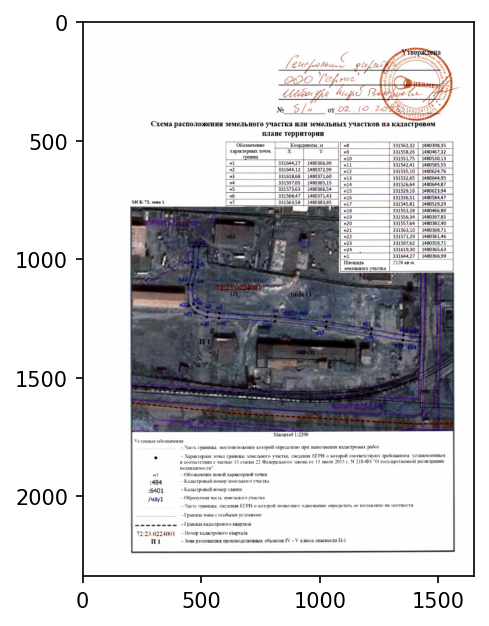

In [767]:
# img = cv2.imread('../dataset/val/Схема расположения ПС_page_0.jpg')
# img = cv2.imread('../dataset/train/202309180001')

fig = plt.figure(dpi = 150)
img = cv2.imread('../dataset/table_img/231003056_page_0.jpg')
# img = cv2.imread('../dataset/all_table/202308310001_page_4.jpg')
plt.imshow(img)

In [768]:
from nms import non_max_suppression
def preprocess_image(image):
    if image.shape[2] == 4:
        # convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    # image = letterbox_image(image)
    image = cv2.resize(image, (736, 736))
    image = image / image.max()
    image_norm = image.copy()
    batch = torch.tensor(image[np.newaxis, :], dtype=torch.float).permute(0, 3, 1, 2)
    return batch, image_norm

model = ort.InferenceSession("./best.onnx")
batch, source = preprocess_image(img)
outputs = model.run(None, {"images": batch.numpy()})  # Print Result
predict = non_max_suppression(
                torch.tensor(outputs[0]), conf_thres=0.5, iou_thres=0.8
            )[0]


img_show = img.copy()
_cls = predict[:, 5]
table_predicts = predict[_cls == 0]

h_orig, w_orig = img.shape[:2]
h_crop, w_crop = source.shape[:2]
h_rate = h_orig / h_crop
w_rate = w_orig / w_crop
print(outputs)

[array([[[     5.1907,      12.576,       19.38, ...,      618.79,      652.04,      694.34],
        [     20.575,      11.836,       4.958, ...,      668.12,      682.82,      673.78],
        [     9.6819,      22.933,      38.851, ...,      159.44,       177.6,       278.5],
        [     41.163,      23.676,      9.8396, ...,      342.73,      356.19,      309.99],
        [ 2.6226e-06,   2.265e-06,  1.3113e-06, ...,  3.1501e-05,  8.9109e-06,  5.9903e-06],
        [ 4.0531e-06,  5.9605e-07,  1.1921e-07, ...,  2.8431e-05,  1.6302e-05,  1.1086e-05]]], dtype=float32)]


In [769]:
def sort_table_predict(predicts):
    list_pred = []
    for t_pred in predicts:
        x1, y1, x2, y2 = t_pred[:4].detach().cpu().numpy()
        list_pred.append({"x": x1, "y": y1, "pred": t_pred})
    sort_by_x = sorted(list_pred, key=lambda x: x["x"])
    # print(sort_by_x)
    if len(sort_by_x) == 2:
        if sort_by_x[0]["y"] > sort_by_x[1]["y"]:
            return [x["pred"] for x in [sort_by_x[1], sort_by_x[0]]]  # переставить
        else:
            return [x["pred"] for x in sort_by_x]

    def sorted_with_y(list_items, sorted_list):
        if len(list_items) == 0:
            return sorted_list
        min_x = list_items[0]["x"]
        y_min = 10000
        min_item = list_items[0]
        for item in list_items:
            if item["y"] < y_min and item["x"] < min_x:
                # if item["y"] < y_min:
                y_min = item["y"]
                min_item = item
        sorted_list.append(min_item)
        list_items.remove(min_item)
        sorted_with_y(list_items, sorted_list)

        return sorted_list

    sorted_predict = []
    sorted_with_y(sort_by_x, sorted_predict)

    return [x["pred"] for x in sorted_predict]

In [770]:
img_show = img.copy()
_cls = predict[:, 5]
table_predicts = predict[_cls == 0]
# table_predicts = predict
fig = plt.figure(dpi = 250)
sort_table_predicts = sort_table_predict(table_predicts)

<Figure size 1600x1200 with 0 Axes>

In [771]:
from skimage.filters import unsharp_mask

In [772]:
table_predicts

tensor([[4.8278e+02, 1.6081e+02, 6.9372e+02, 3.2409e+02, 9.1903e-01, 0.0000e+00],
        [2.9459e+02, 1.8230e+02, 4.8057e+02, 2.4703e+02, 5.9422e-01, 0.0000e+00]])

tensor(482.7765) tensor(160.8131) tensor(693.7234) tensor(324.0895)
1084 511 1558 1029
tensor(294.5889) tensor(182.2956) tensor(480.5748) tensor(247.0271)
661 579 1079 785


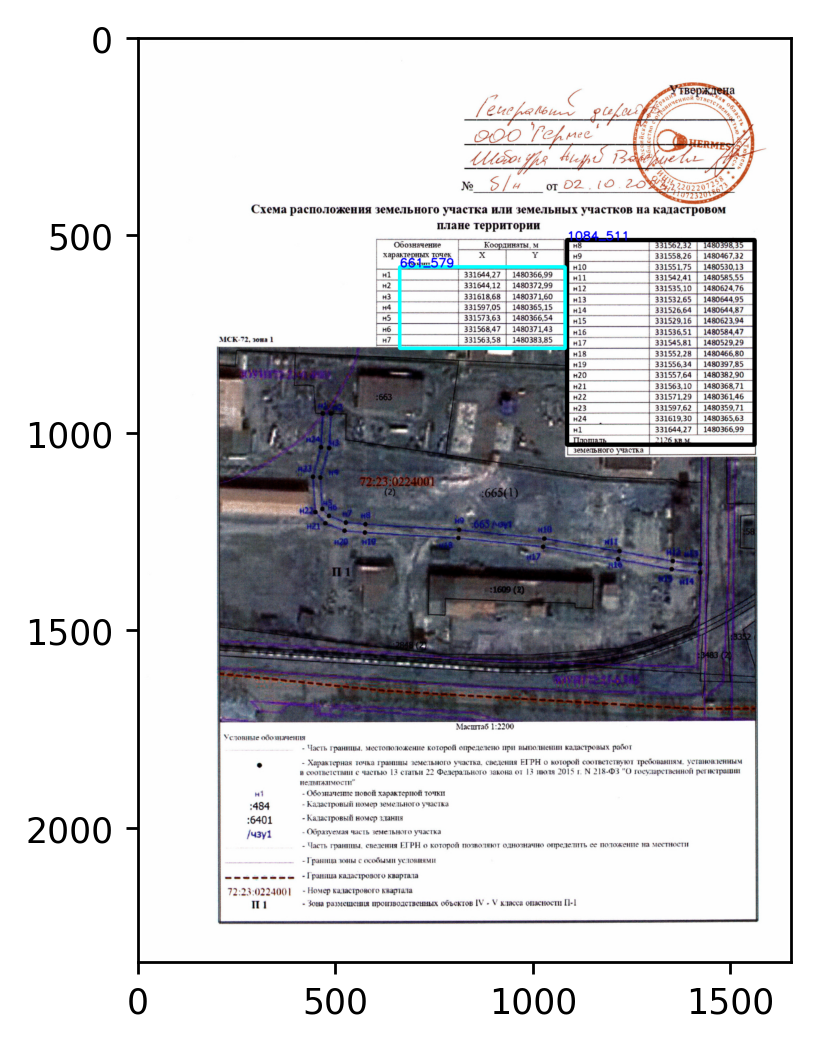

In [773]:
predict = non_max_suppression(
                torch.tensor(outputs[0]), conf_thres=0.5, iou_thres=0.1
            )[0]


img_show = img.copy()
_cls = predict[:, 5]
table_predicts = predict[_cls == 0]
# table_predicts = predict
fig = plt.figure(dpi = 250)
sort_table_predicts = sort_table_predict(table_predicts)
colors = {0:(0,0,0),1:(0,255,255),2:255,3:150,4:124,5:178,6:145,7:145,8:145,9:224,10:112}
for i,t_pred in enumerate(sort_table_predicts):
    x1, y1, x2, y2 = t_pred[:4]
    print(x1, y1, x2, y2, )
    x1, y1, x2, y2 = (
        int(x1 * w_rate),
        int(y1 * h_rate),
        int(x2 * w_rate),
        int(y2 * h_rate),
    )
    print(x1, y1, x2, y2)
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (x1, y1) 

    # fontScale 
    fontScale = 1

    # Red color in BGR 
    color = (0, 0, 255) 

    # Line thickness of 2 px 
    thickness = 2
    cv2.rectangle(img_show, (x1, y1), (x2, y2), colors[i],10-i*3) 
    # Using cv2.putText() method 
    img_show = cv2.putText(img_show, f"{x1}_{y1}", org, font, fontScale,  
                     color, thickness, cv2.LINE_AA, False)


plt.imshow(img_show)

In [774]:
sort_table_predicts

[tensor([482.7765, 160.8131, 693.7234, 324.0895,   0.9190,   0.0000]),
 tensor([294.5889, 182.2956, 480.5748, 247.0271,   0.5942,   0.0000])]

(206, 418, 3)


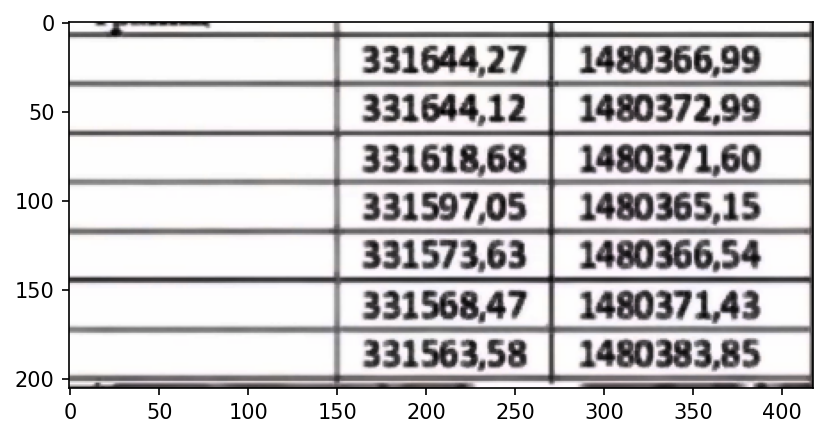

In [796]:
x1,y1, x2, y2 = sort_table_predicts[1][:4]
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
x1, y1, x2, y2 = (
        int(x1 * w_rate),
        int(y1 * h_rate),
        int(x2 * w_rate),
        int(y2 * h_rate),
    )

img_crop = img[y1:y2, x1:x2]
# angle, img_crop = correct_skew(img_crop)
img_denois = cv2.fastNlMeansDenoisingColored(img_crop, None, 10, 10, 7, 15)                       
img_crop = cv2.erode(img_denois,kernel = np.ones((2,2), np.uint8))

# img_crop = (np.around((unsharp_mask(img_crop)),2)*255).astype(np.uint8)
# img_crop = cv2.erode(img_crop,kernel = np.ones((2,2), np.uint8))

# img_crop = get_grayscale(img_crop)
# img_crop = thresholding(img_crop)
# img_crop = dilate(img_crop)
# img_crop = opening(img_crop)
# img_crop = deskew(img_crop)

print(img_crop.shape)
fig = plt.figure(dpi = 150)
plt.imshow(img_crop)

In [797]:
h,w, c =img_crop.shape

In [798]:
# ocr_model = detection_predictor(arch='db_resnet50', pretrained=True)
# checkpoint = torch.load('../doctr/db_resnet50_20231225-175311.pt', map_location="cuda")
# ocr_model.model.load_state_dict(checkpoint)

array([    0.38477,    0.052734,     0.62891,     0.16504,      0.8103])

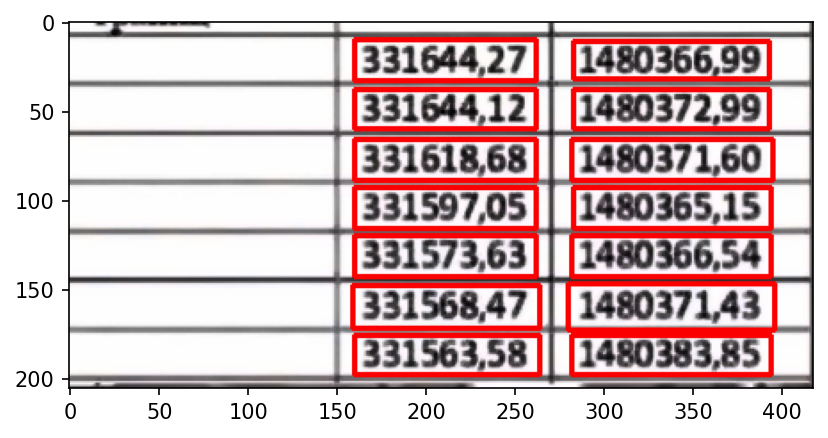

In [799]:
# ocr_model = detection_predictor(arch='db_resnet50', pretrained='../doctr/db_resnet50_20231225-153643.pt')
input_page = (255 * np.random.rand(600, 800, 3)).astype(np.uint8)
out = ocr_model([img_crop])
fig = plt.figure(dpi = 150)
ax = fig.gca()
ax.imshow(img_crop)
for k,box in enumerate(out[0]['words']):
    x1,y1, x2, y2 = box[:4]
    x1 = int(x1*w)
    x2 = int(x2*w)
    y1 = int(y1*h)
    y2 = int(y2*h)
    cv2.rectangle(img_crop, (x1, y1), (x2, y2), color = 251, thickness = 2) 
ax.imshow(img_crop)
box

In [800]:
ocr_det = detection_predictor(arch='db_resnet50', pretrained=True)
input_page = (255 * np.random.rand(600, 800, 3)).astype(np.uint8)
out = ocr_det([img_crop])
out

[{'words': array([[    0.37207,     0.85547,     0.62988,     0.95996,     0.67234],
         [    0.35156,      0.7041,     0.95117,     0.84766,      0.5456],
         [    0.83789,     0.59961,     0.93457,     0.67285,     0.43965],
         [    0.67676,      0.5957,     0.76855,     0.67969,     0.50637],
         [    0.36816,     0.58398,     0.64258,      0.6875,      0.5515],
         [    0.87793,     0.49121,     0.91797,      0.5332,     0.36255],
         [    0.38379,     0.46973,     0.45801,     0.54102,     0.61485],
         [    0.67871,     0.46289,     0.77832,     0.54785,     0.61866],
         [    0.66602,     0.32422,     0.94141,     0.42676,     0.76537],
         [    0.36816,     0.32422,      0.6377,     0.42773,     0.80564],
         [    0.66992,     0.18457,     0.94238,     0.29199,     0.73199],
         [    0.51172,     0.18945,     0.64551,     0.28613,     0.56046],
         [    0.37207,     0.18555,     0.51562,     0.28613,     0.46655],
   

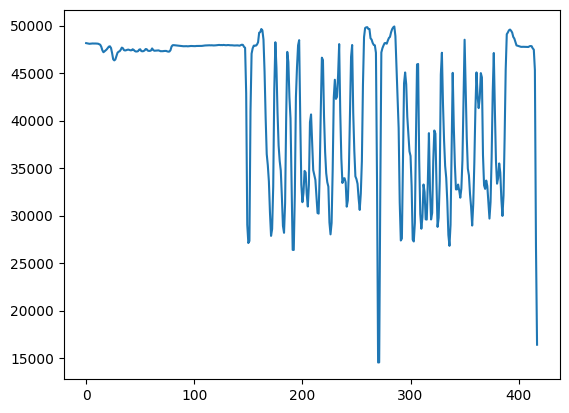

In [801]:
plt.plot(img_crop[:,:,0].sum(axis=0))

In [802]:
ocr = ocr_predictor(reco_arch='crnn_mobilenet_v3_large', pretrained=True, detect_language=True, detect_orientation = True)

In [803]:
# ocr = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_mobilenet_v3_large', pretrained=True, detect_orientation = False)
# checkpoint = torch.load('../doctr/db_resnet50_20231225-175311.pt', map_location="cuda")
# ocr.det_predictor.model.load_state_dict(checkpoint)

In [804]:
result = ocr([img_crop])
pages = result.export()['pages']
blocks = pages[0]['blocks']
print(len(blocks))
#blocks

14


2339 1653


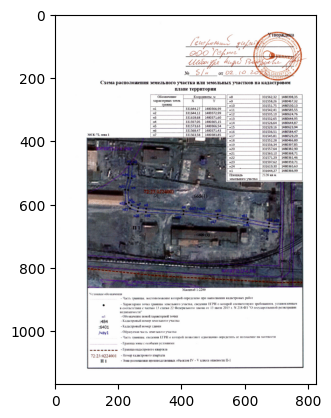

In [856]:
w,h, c = img.shape
print(w,h)
image_resize = cv2.resize(img, ( int(h / 2), int(w / 2)))
plt.imshow(image_resize)

In [841]:
result

Document(
  (pages): [Page(
    dimensions=(206, 418)
    (blocks): [
      Block(
        (lines): [Line(
          (words): [Word(value='331644,27', confidence=0.99)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='1480366,99', confidence=1.0)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='331644,12', confidence=0.99)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='1480372,99', confidence=0.78)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='331618,68', confidence=1.0)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='1480371,60', confidence=1.0)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='331

In [805]:
coords = []
for b in blocks:
    for l in b['lines']:
        for w in l['words']:
            p1 = np.array(w['geometry'][0])
            p2 = np.array(w['geometry'][1])
            centr = (p2 + p1)/2
            coords.append({'value':w['value'],'x_c':centr[0],'y_c':centr[1]})

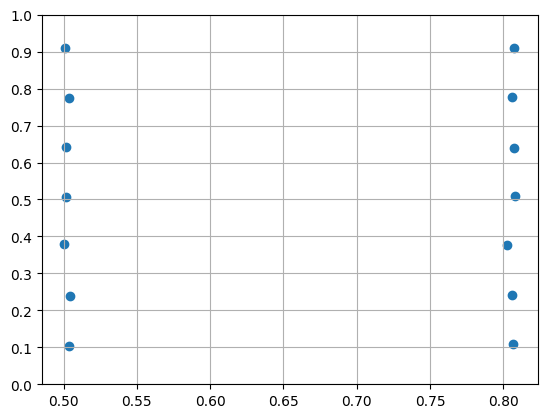

In [806]:
x = [x['x_c'] for x in coords]
y = [x['y_c'] for x in coords]
plt.scatter(x,y)
plt.grid()
plt.yticks(np.linspace(0,1,11));

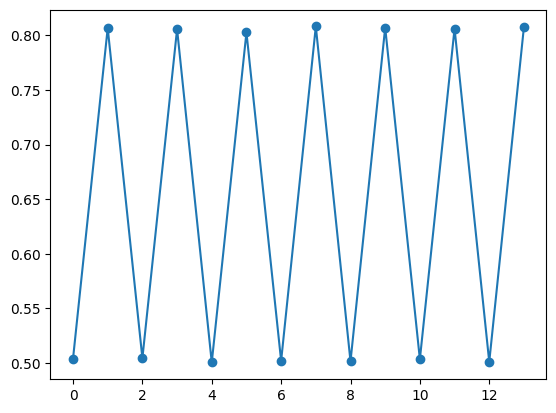

In [807]:
plt.plot(x)
plt.scatter(range(len(x)),x)

In [832]:
from sklearn.cluster import KMeans

class Table:
    def __init__(self):
        self.arr_xpos = None
        self.arr_ypos = None

    def check_centers(self):
        if abs(self.centers[1] - self.centers[0]) / self.centers[1] * 100 < 10:
            print("Координаты для кластера '№ номер' и 'X' совпали")
            self.centers[0] = 0.01
        if abs(self.centers[1] - self.centers[2]) / self.centers[1] * 100 < 10:
            print("Координаты для кластера 'X' и 'Y' совпали")
            self.centers[1] = self.centers[0]
            self.centers[0] = 0.001
    def from_coords(self, list_coords):
        print(len(list_coords))
        # центры класстеров по x coorditane каждого разпознаного объекта
        self.arr_xpos = np.array([x["x_c"] for x in list_coords])
        self.arr_ypos = np.array([x["y_c"] for x in list_coords])
        # центры класстеров по х для объектов
        cluster_centers = np.array([[self.arr_xpos.min(), self.arr_xpos.mean(), self.arr_xpos.max()]]).T
        kmean = KMeans(init = cluster_centers, n_clusters=3, n_init=1)
        kmean.fit(self.arr_xpos.reshape(-1, 1))

        
        self.centers = np.sort(kmean.cluster_centers_.T[0])
        print(self.centers)
        self.check_centers()
        
        print(self.centers)
        lst_number, lst_X, lst_Y = [], [], []
        for item in list_coords:
            number_pos = np.argmin(
                [
                    abs(item["x_c"] - self.centers[0]),
                    abs(item["x_c"] - self.centers[1]),
                    abs(item["x_c"] - self.centers[2]),
                ]
            )
            if number_pos == 0:
                lst_number.append(item.copy())
            elif number_pos == 1:
                lst_X.append(item.copy())
            elif number_pos == 2:
                lst_Y.append(item.copy())
        print(f"Списки: {len(lst_number)} и {len(lst_X)} и {len(lst_Y)}")
        self.lst_number = lst_number
        self.lst_X = lst_X
        self.lst_Y = lst_Y
        # self.lst_number = self.connect_part_in_column(self.lst_number)

        self.X_before = lst_X.copy()
        self.Y_before = lst_Y.copy()

        # if len(self.lst_X) != len(self.lst_Y):
        #     self.lst_X = self.connect_part_in_column(self.lst_X)
        #     self.lst_Y = self.connect_part_in_column(self.lst_Y)

        self.lst_X = self.merge_paths_column_list(self.lst_X)
        self.lst_Y = self.merge_paths_column_list(self.lst_Y)
        print(f"Списки: {len(self.lst_X)} и {len(self.lst_Y)}")
        # проверка элементов to float
        # if len(self.lst_X) != len(self.lst_Y):
        #     for k,item in enumerate(self.lst_X):
        #         try:
        #             value = self.string_to_float(item['value'])
        #             self.lst_X[k]['value'] = value
        #         except:
        #             del self.lst_X[k]
        #     for k,item in enumerate(self.lst_Y):
        #         try:
        #             value = self.string_to_float(item['value'])
        #             self.lst_Y[k]['value'] = value
        #         except:
        #             del self.lst_Y[k]
        # else:
        #     for k, (x_item,y_item) in enumerate(zip(self.lst_X, self.lst_Y)):
        #         self.lst_X[k]['value'] = self.string_to_float(x_item['value'])
        #         self.lst_Y[k]['value'] = self.string_to_float(y_item['value'])

        print(f"Списки: {len(self.lst_X)} и {len(self.lst_Y)}")
        self._create_cells(self.lst_number, self.lst_X, self.lst_Y)
        self.arr_xpos = np.array(
            [x["x_c"] for x in list(self.lst_number + self.lst_X + self.lst_Y)]
        )
        self.arr_ypos = np.array(
            [x["y_c"] for x in list(self.lst_number + self.lst_X + self.lst_Y)]
        )
        return self.cells

    def _create_cells(self, lst_number, lst_X, lst_Y):
        if len(lst_X) == len(lst_Y):
            self.cells = [[None for j in range(3)] for i in range(len(lst_X))]
            for i, (x_v, y_v) in enumerate(zip(lst_X, lst_Y)):
                self.cells[i][0] = self.get_nearest_number(x_v)
                self.cells[i][1] = x_v
                self.cells[i][2] = y_v
        else:
            number_line = max(len(lst_X), len(lst_Y))
            self.cells = [[None for j in range(3)] for i in range(number_line)]
            if len(lst_X) > len(lst_Y):
                for k, item in enumerate(lst_X):
                    self.cells[k][0] = self.get_nearest_number(item)
                    self.cells[k][1] = item
                    self.cells[k][2] = self.get_nearest_item_in_table(item, lst_Y)
            else:
                for k, item in enumerate(lst_Y):
                    self.cells[k][0] = self.get_nearest_number(item)
                    self.cells[k][1] = self.get_nearest_item_in_table(item, lst_X)
                    self.cells[k][2] = item
        return self.cells

    @property
    def X_xposition(self):
        return np.array([a["x_c"] for a in self.lst_X])

    @property
    def Y_xposition(self):
        return np.array([a["x_c"] for a in self.lst_Y])

    @property
    def varience(self):
        yvar_X = np.array([x["x_c"] for x in self.lst_X]).var()
        yvar_Y = np.array([x["x_c"] for x in self.lst_Y]).var()
        return yvar_X, yvar_Y

    def get_nearest_number(self, x_value):
        """
        Получить номер(первый столбец) точки для текущей координаты X(второй столбец) по позиции в изображении x_c и y_c
        """
        yc = x_value["y_c"]
        ypos_number = np.array([x["y_c"] for x in self.lst_number])
        if len(ypos_number) == 0:
            return {
                "value": "Err",
                "x_c": self.centers[0],
                "y_c": yc,
            }

        ypos_X = np.array([x["y_c"] for x in self.lst_X])
        cell_height = (
            ypos_X[1:] - ypos_X[:-1]
        ).mean()  # шаг между координатой по Y(высота ячейки в таблицe)

        delta = abs(ypos_number - yc)
        index = np.argmin(delta)
        if delta[index] <= cell_height * (0.9):
            return self.lst_number[index]
        else:
            return {
                "value": "Err",
                "x_c": np.array([x["x_c"] for x in self.lst_number]).mean(),
                "y_c": yc,
            }

    def get_nearest_item_in_table(self, x_value, list_coords):
        """
        Получить Y(3-й столбец) координату для текущей координаты X(второй столбец)
        """
        yc = x_value["y_c"]
        ypos_Y = np.array([x["y_c"] for x in list_coords])

        # ypos_Y = np.array([x['y_c'] for x in self.lst_Y])
        # ypos_X = np.array([x['y_c'] for x in self.lst_X])

        cell_height = (abs(ypos_Y[1:] - ypos_Y[:-1])).mean()
        delta = abs(ypos_Y - yc)
        index = np.argmin(delta)
        if delta[index] <= cell_height * (0.9):
            return list_coords[index]
        else:
            return {
                "value": "Err",
                "x_c": np.array([x["x_c"] for x in list_coords]).mean(),
                "y_c": yc,
            }

    def connect_part_in_column(self, list_items):
        """
        Соединить части координат в столбце
        """

        def find_other_part(list_items, first_item):
            rmin = 1000
            second_item = None
            for item in list_items:
                if item == first_item:
                    continue
                r = abs(item["y_c"] - first_item["y_c"])
                if r < rmin:
                    rmin = r
                    second_item = item
            return second_item

        def connect_paths_val(first, second):
            val = first["value"].replace(" ", "").replace(".", "") + second[
                "value"
            ].replace(" ", "")
            return val

        arr_x = np.array([a["x_c"] for a in list_items])
        x_mean = arr_x.mean()
        x_var = arr_x.var()
        result_list = []
        visited = []
        min_length = np.array([len(x["value"]) for x in list_items]).mean()
        for item in list_items:
            if item in visited:
                continue
            r = abs(item["x_c"] - x_mean) ** 2
            cur_len = len(item["value"])
            if cur_len < min_length - 1:
                second_item = find_other_part(list_items, item)
                # print(item, second_item)
                visited.append(second_item)
                new_item = {
                    "value": connect_paths_val(item, second_item),
                    "x_c": x_mean,
                    "y_c": (item["y_c"] + second_item["y_c"]) * 0.5,
                }
                result_list.append(new_item)
            else:
                result_list.append(item)
        return result_list

    @property
    def frame(self):
        return pd.DataFrame(
            {
                "N": [c[0]["value"] for c in self.cells],
                "X": [c[1]["value"] for c in self.cells],
                "Y": [c[2]["value"] for c in self.cells],
            }
        )

    @staticmethod
    def string_to_float(string):
        if type(string) == float:
            return string
        result = string
        result = result.replace("\\", "")
        result = result.replace("/", "").replace("%", "")
        if result.count(".") > 1:
            parts = result.split(".")
            result = "".join(parts[:-1]) + "." + parts[-1]
        if result.count(",") > 1:
            parts = result.split(",")
            result = "".join(parts[:-1]) + "." + parts[-1]
        if result.count(",") == 1 and result.count(".") == 1:
            result = result.replace(",", ".")
            parts = result.split(".")
            result = "".join(parts[:-1]) + "." + parts[-1]

        ans = []
        for s in result:
            if s in ",.0123456789":
                ans.append(s)
        result = "".join(ans)
        if len(result) == 1:
            if result not in "0123456789":
                return -1
        if len(result) == 0:
            return 0
        return float(result.replace(",", "."))

    def merge_paths_column_list(self, list_items):
        ycoords = np.array([x["y_c"] for x in list_items])
        y_diff = ycoords[1:] - ycoords[:-1]
        index = np.where(y_diff > y_diff.mean())[0]
        yc_lvl = ycoords[index]

        n = len(y_diff)
        if n < 5:
            mean_delta = y_diff.mean()
        else:
            mean_delta = np.sort(y_diff)[3:].mean()

        ymain_lvl = [ycoords[0]]
        for v in ycoords:
            delta = abs(v - ymain_lvl[-1])
            if delta < mean_delta * 0.3:
                continue
            else:
                ymain_lvl.append(v)

        items_on_lvl = {f"{i}": [] for i, item in enumerate(ymain_lvl)}
        for v in list_items:
            k = np.argmin(abs(np.array(ymain_lvl) - v["y_c"]))
            items_on_lvl[str(k)].append(v)

        new_items_list = []
        for k, items in items_on_lvl.items():
            if len(items) > 1:
                val = "".join([str(v["value"]) for v in items])
                val = val.replace("-", "")
                yc = np.array([v["y_c"] for v in items]).mean()
                xc = np.array([v["x_c"] for v in items]).mean()
                new_items_list.append({"value": val, "x_c": xc, "y_c": yc})
            else:
                new_items_list.append(items[0])
        return new_items_list

In [834]:
coords = []
for b in blocks:
    for l in b['lines']:
        for w in l['words']:
            p1 = np.array(w['geometry'][0])
            p2 = np.array(w['geometry'][1])
            centr = (p2 + p1)/2
            coords.append({'value':w['value'],'x_c':centr[0],'y_c':centr[1]})
table = Table()
cells = table.from_coords(coords.copy())

14
[    0.50237     0.80273     0.80688]
Координаты для кластера 'X' и 'Y' совпали
[      0.001     0.50237     0.80688]
Списки: 0 и 7 и 7
Списки: 7 и 7
Списки: 7 и 7


In [835]:
df = table.frame
all(df.iloc[-1,1:] == df.iloc[0,1:])

False

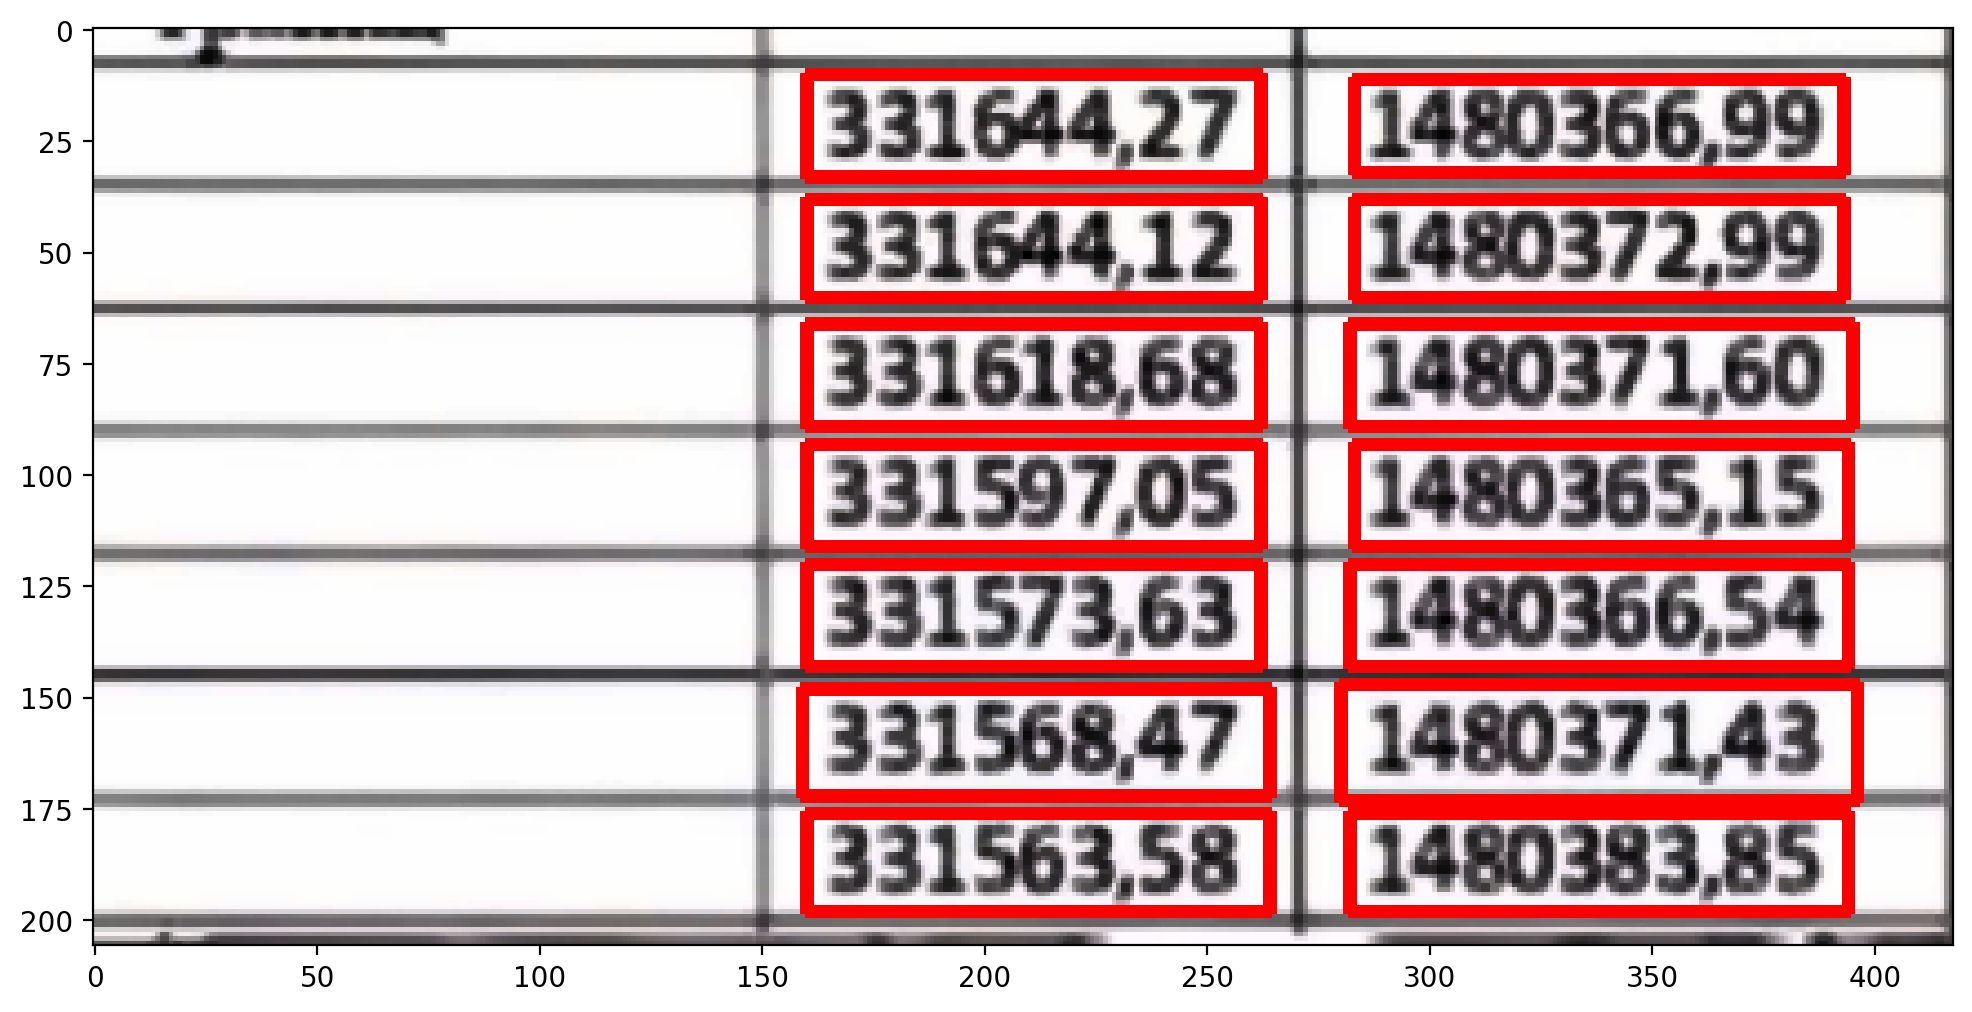

In [838]:
fig = plt.figure(dpi = 200,figsize = (12,8))
plt.imshow(img_crop)

In [839]:
table.frame.tail(40)

N          X           Y
0  Err  331644,27  1480366,99
1  Err  331644,12  1480372,99
2  Err  331618,68  1480371,60
3  Err  331597,05  1480365,15
4  Err  331573,63  1480366,54
5  Err  331568,47  1480371,43
6  Err  331563,58  1480383,85

In [840]:
img_crop.shape

(206, 418, 3)

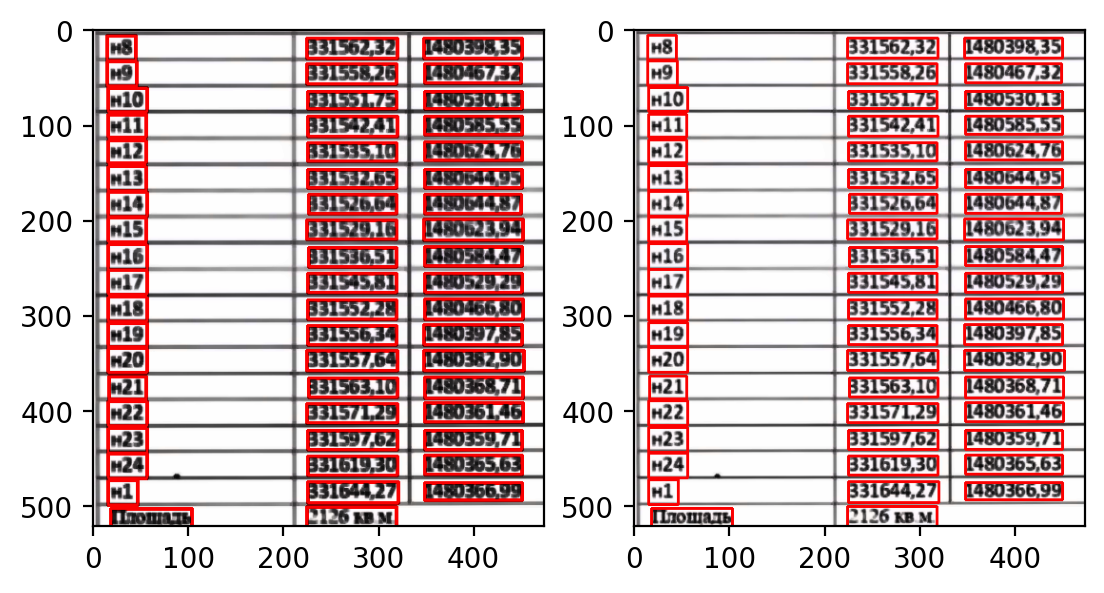

In [793]:
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(img_crop, cv2.MORPH_OPEN, kernel)
img_denois = cv2.fastNlMeansDenoisingColored(img_crop, None, 10, 10, 7, 15)                       
img_erod = cv2.erode(img_denois,kernel = np.ones((2,2), np.uint8))

# th3 = cv2.adaptiveThreshold(img_crop[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# temp = np.zeros((*th3.shape,3))
# temp[:,:,0] = th3
# temp[:,:,1] = th3
# temp[:,:,2] = th3

# th_den = cv2.fastNlMeansDenoisingColored(img_denois, None, 10, 10, 7, 15)                       

fig,ax = plt.subplots(1,2, dpi = 200)
ax[0].imshow(img_erod)
ax[1].imshow(img_denois)

<Figure size 640x480 with 0 Axes>

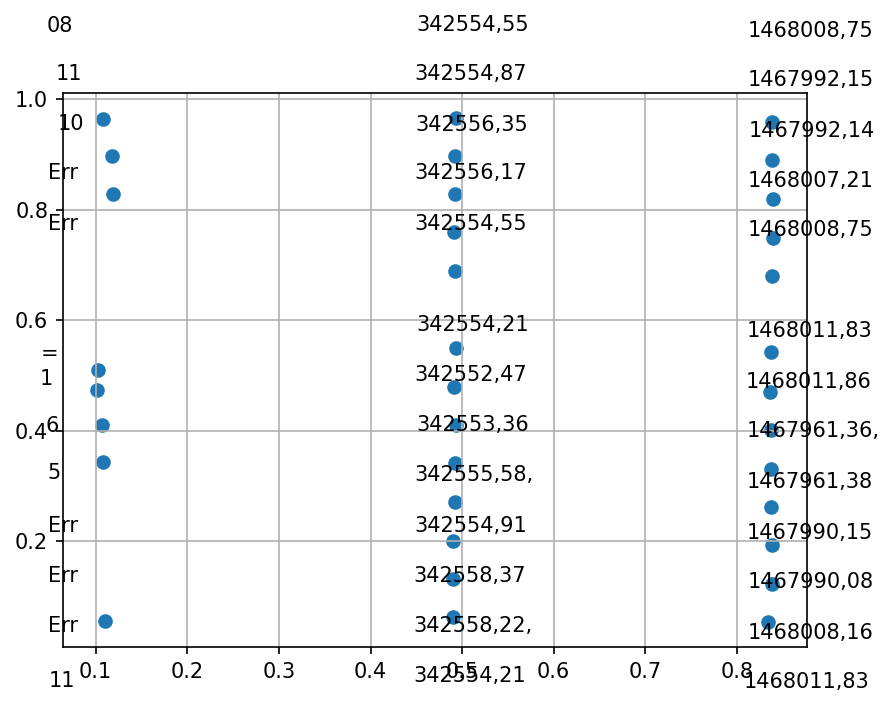

In [733]:
cells = table.cells
fig = plt.figure(dpi = 100)
fig = plt.figure(dpi = 150)
for line in cells:
    for c in line:
        try:
            # print(c['value'],c['x_c'],c['y_c'])
            fig.text(c['x_c'],c['y_c'],c['value'])
        except:
            pass
x = [x for x in table.arr_xpos]
y = [x for x in table.arr_ypos]

plt.scatter(x,y)      
plt.grid()

In [734]:
x_mean = table.X_xposition.mean()
x_var = table.X_xposition.var()
for item in table.lst_X:
    r = abs(item['x_c'] - x_mean)**2
    if r>x_var/2:
        print(item['value'], abs(item['x_c'] - x_mean)**2)
        

342554,21 2.037138628536403e-06
342558,22, 3.6693889008470918e-06
342558,37 2.037138628536403e-06
342553,36 3.962827152049082e-06
342554,21 2.2572173169378953e-06
342554,55 2.2572173169378953e-06


In [646]:
coords = []
d = {}
for i, b in enumerate(pages[0]['blocks']):
    lines = b['lines']
    for i,l in enumerate(lines):
        print(l['words'], len(lines))
        if i == 0:
            d['N'] = l['words']
        elif i == 1:
            d['X'] = l['words']
        elif i == 2:
            d['Y'] = l['words']
    coords.append(d)
    if i+1%3==0:
        pass

[{'value': '329186.20', 'confidence': 0.9998998641967773, 'geometry': ((0.5014238394365348, 0.015625), (0.5654966140805985, 0.02734375))}] 81
[{'value': '329139.50', 'confidence': 0.5421580076217651, 'geometry': ((0.5014238394365348, 0.02734375), (0.5654966140805985, 0.0390625))}] 81
[{'value': '329112.10', 'confidence': 0.9995762705802917, 'geometry': ((0.5014238394365348, 0.0380859375), (0.5654966140805985, 0.0498046875))}] 81
[{'value': '329073.80', 'confidence': 0.9974063038825989, 'geometry': ((0.5014238394365348, 0.048828125), (0.5654966140805985, 0.060546875))}] 81
[{'value': '328573.40', 'confidence': 0.9602092504501343, 'geometry': ((0.5014238394365348, 0.060546875), (0.5654966140805985, 0.072265625))}] 81
[{'value': '328552.30', 'confidence': 0.9609602093696594, 'geometry': ((0.5, 0.0693359375), (0.5669204535171332, 0.083984375))}] 81
[{'value': '328558.80', 'confidence': 0.9995929598808289, 'geometry': ((0.5014238394365348, 0.08203125), (0.5654966140805985, 0.09375))}] 81
[{

In [60]:
for cell in table.cells:
    cell[1]['value'] = table.string_to_float(cell[1]['value'])
    cell[2]['value'] = table.string_to_float(cell[2]['value'])

In [61]:

print(len(pages))
blocks = pages[0]['blocks']
print(len(blocks))

df = pd.DataFrame()
for i,block in enumerate(blocks):
    # print(block['lines'])
    if i == 0:
        df = pd.DataFrame(l['words'][0]['value'] for l in block['lines'])
    else:
        _df = pd.DataFrame(l['words'][0]['value'] for l in block['lines'])
        df=pd.concat((df,_df), axis = 1)
df

1
23


0          0           0   0          0           0  0          0  \
0  I  342975.83  1460712.82  2]  342985.37  1460703.53  3  342985.24   

            0  0  ...           0          0          0        0           0  \
0  1460702.18  4  ...  1460671.92  634302046  4000/1.0/  7343008  1400042.39   

   0            0  0         0          0  
0  8  1460627.511  a  R4200308  146063305  

[1 rows x 23 columns]

In [2059]:
for f in Path('../dataset/all_table/').glob("*.jpg"):
    img_crop = cv2.imread(str(f))
    print(img_crop.mean(), np.sqrt(img_crop.var()), f)

239.06953625112843 47.91327626208543 ../dataset/all_table/Схема_общ_page_1.jpg
239.55352548443193 47.06862391530513 ../dataset/all_table/202310040001_page_1.jpg
246.3579963575917 40.64965011909693 ../dataset/all_table/схема границ публичного сервитута_page_0.jpg
238.87893751420907 49.44487562573732 ../dataset/all_table/202309220001_page_1.jpg
252.13517495881794 24.04072100872429 ../dataset/all_table/Схема расположениякоординаты_page_1.jpg
243.68751578247313 43.915904470241124 ../dataset/all_table/Схема перераспределения земельного участка на кадастровом плане территории_page_0.jpg
242.74599574570476 42.98829095810272 ../dataset/all_table/202310180001_page_0.jpg
249.5553533847149 24.6787809537297 ../dataset/all_table/202309250001_page_0.jpg
240.33550615287558 52.71095531552223 ../dataset/all_table/схема ПС_page_0.jpg
243.29341878137032 51.12856466792646 ../dataset/all_table/Схема на КПТ_page_1.jpg
233.84637955993313 46.62882104620666 ../dataset/all_table/202310090001_page_0.jpg
241.5002

In [252]:
def sort_table_predict(predicts):
    list_pred = []
    for t_pred in predicts:
        x1, y1, x2, y2 = t_pred[:4].detach().cpu().numpy()
        list_pred.append({"x": x1, "y": y1, "pred": t_pred})
    sort_by_x = sorted(list_pred, key=lambda x: x["x"])
    print(sort_by_x)
    if len(sort_by_x) == 2:
        if sort_by_x[0]['y'] > sort_by_x[1]['y']:
            return [x["pred"] for x in [sort_by_x[1], sort_by_x[0]]] #переставить
        else:
            return [x["pred"] for x in sort_by_x]
        
    def sorted_with_y(list_items, sorted_list):
        if len(list_items) == 0:
            return sorted_list
        min_x = list_items[0]["x"]
        y_min = 10000
        min_item = list_items[0]
        for item in list_items:
            if item["y"] < y_min and item["x"] < min_x:
                # if item["y"] < y_min:
                y_min = item["y"]
                min_item = item
        sorted_list.append(min_item)
        list_items.remove(min_item)
        sorted_with_y(list_items, sorted_list)

        return sorted_list

    sorted_predict = []
    sorted_with_y(sort_by_x, sorted_predict)

    return [x["pred"] for x in sorted_predict]

In [241]:
"230913080_page_0.jpg" "230920041_page_0.jpg" "231031049_page_2.jpg"

'230913080_page_0.jpg230920041_page_0.jpg231031049_page_2.jpg'

In [489]:
def rotate_image(image, angle):
    (h, w) = image.shape[: 2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
    return corrected

def determine_score(arr):
    histogram = np.sum(arr, axis = 2, dtype = float)
    score = np.sum((histogram[..., 1 :] - histogram[..., : -1]) ** 2, axis = 1, dtype = float)
    return score

def correct_skew(image, delta = 0.1, limit = 5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    angles = np.arange(-limit, limit + delta, delta)
    img_stack = np.stack([rotate_image(thresh, angle) for angle in angles], axis = 0)
    scores = determine_score(img_stack)
    best_angle = angles[np.argmax(scores)]
    corrected = rotate_image(image, best_angle)
    return best_angle, corrected

In [89]:
from nms import non_max_suppression
def preprocess_image(image):
    if image.shape[2] == 4:
        # convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    # image = letterbox_image(image)
    image = cv2.resize(image, (736, 736))
    image = image / image.max()
    image_norm = image.copy()
    batch = torch.tensor(image[np.newaxis, :], dtype=torch.float).permute(0, 3, 1, 2)
    return batch, image_norm
import torch
import onnxruntime as ort


img = cv2.imread("../dataset/table_img/230920041_page_0.jpg")
# angle, img = correct_skew(img)

model = ort.InferenceSession("./best.onnx")
batch, source = preprocess_image(img)
outputs = model.run(None, {"images": batch.numpy()})  # Print Result

h_orig, w_orig = img.shape[:2]
h_crop, w_crop = source.shape[:2]
h_rate = h_orig / h_crop
w_rate = w_orig / w_crop
print(outputs)

[array([[[     4.8229,      13.626,      19.917, ...,      649.14,      672.96,      676.78],
        [     19.548,       10.36,      4.4632, ...,      662.67,      626.77,      619.34],
        [     9.0595,      25.994,      39.723, ...,      193.41,      142.75,      143.23],
        [     39.109,      20.592,      8.7326, ...,      148.64,      218.86,      244.44],
        [ 2.4438e-06,  2.1458e-06,  1.2517e-06, ...,  1.4216e-05,  9.4473e-06,  6.7949e-06],
        [ 3.8147e-06,  4.7684e-07,  1.1921e-07, ...,  2.1935e-05,  2.5839e-05,  1.5199e-05]]], dtype=float32)]


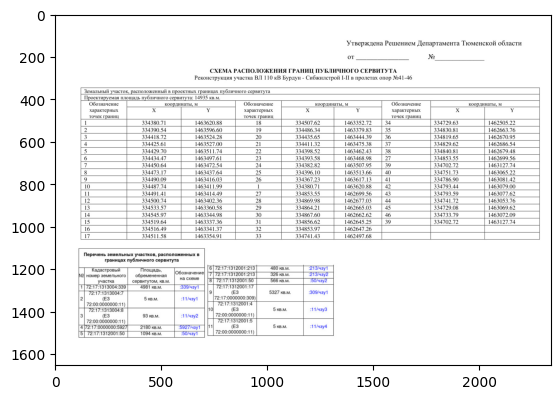

In [90]:
plt.imshow(img)

tensor(40.1980) tensor(221.3573) tensor(273.2613) tensor(474.8521)
127 497 868 1067
tensor(285.6844) tensor(220.8664) tensor(482.2306) tensor(474.7266)
907 496 1532 1066
tensor(486.7268) tensor(218.2490) tensor(718.6725) tensor(442.8058)
1546 490 2283 995


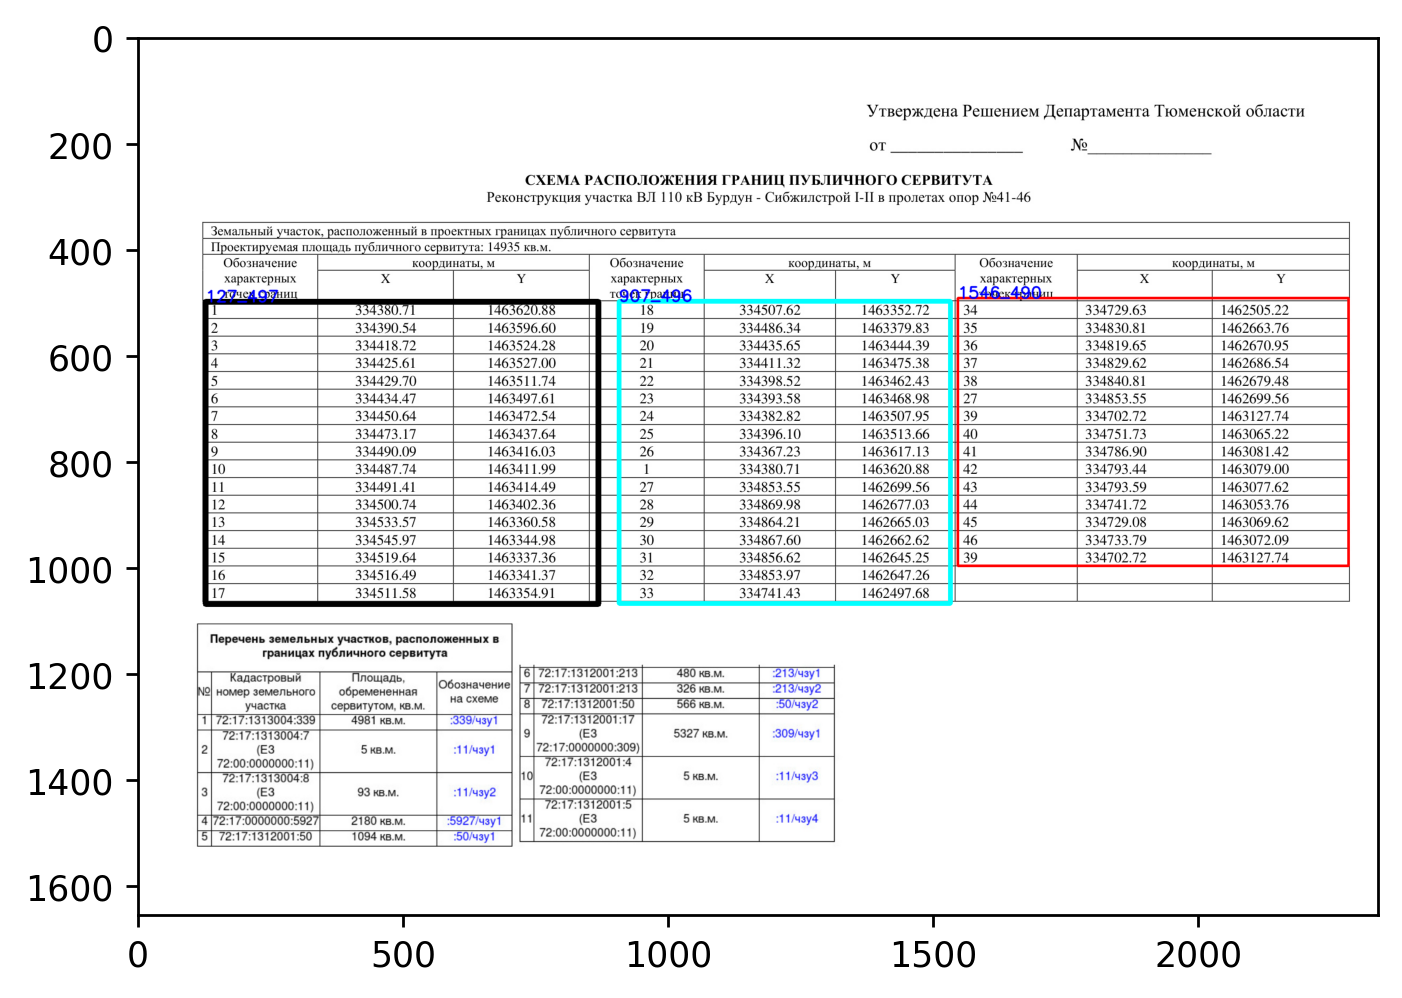

In [91]:
predict = non_max_suppression(
                torch.tensor(outputs[0]), conf_thres=0.5, iou_thres=0.8
            )[0]


img_show = img.copy()
_cls = predict[:, 5]
table_predicts = predict[_cls == 0]
# table_predicts = predict
fig = plt.figure(dpi = 250)
sort_table_predicts = sort_table_predict(table_predicts)
colors = {0:(0,0,0),1:(0,255,255),2:255,3:150,4:124,5:178,6:145,7:145,8:145,9:224,10:112}
for i,t_pred in enumerate(sort_table_predicts):
    x1, y1, x2, y2 = t_pred[:4]
    print(x1, y1, x2, y2, )
    x1, y1, x2, y2 = (
        int(x1 * w_rate),
        int(y1 * h_rate),
        int(x2 * w_rate),
        int(y2 * h_rate),
    )
    print(x1, y1, x2, y2)
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (x1, y1) 

    # fontScale 
    fontScale = 1

    # Red color in BGR 
    color = (0, 0, 255) 

    # Line thickness of 2 px 
    thickness = 2
    cv2.rectangle(img_show, (x1, y1), (x2, y2), colors[i],10-i*3) 
    # Using cv2.putText() method 
    img_show = cv2.putText(img_show, f"{x1}_{y1}", org, font, fontScale,  
                     color, thickness, cv2.LINE_AA, False)


plt.imshow(img_show)

In [92]:
sort_table_predicts

[tensor([ 40.1980, 221.3573, 273.2613, 474.8521,   0.9168,   0.0000]),
 tensor([285.6844, 220.8664, 482.2306, 474.7266,   0.8039,   0.0000]),
 tensor([486.7268, 218.2490, 718.6725, 442.8058,   0.9472,   0.0000])]

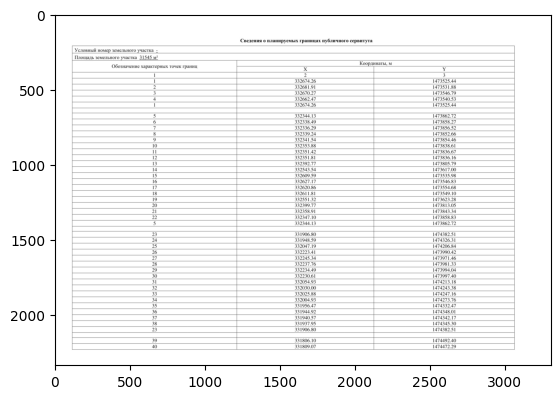

In [438]:
plt.imshow(img)

In [439]:
coords = []
for t_pred in sort_table_predicts:
    x1, y1, x2, y2 = t_pred[:4]

    x1, y1, x2, y2 = (
        int(x1 * w_rate),
        int(y1 * h_rate),
        int(x2 * w_rate),
        int(y2 * h_rate),
    )
    print(x1, y1, x2, y2)
    img_crop = img[y1:y2, x1:x2, :]
    img_crop = cv2.erode(img_crop, kernel=np.ones((2, 2), np.uint8))
    result = ocr([img_crop])
    pages = result.export()["pages"]
    blocks = pages[0]["blocks"]
    coords = []
    for b in blocks:
        for l in b["lines"]:
            for w in l["words"]:
                p1 = np.array(w["geometry"][0])
                p2 = np.array(w["geometry"][1])
                centr = (p2 + p1) / 2
                coords.append(
                    {"value": w["value"], "x_c": centr[0], "y_c": centr[1]}
                )

92 388 2976 2234


In [440]:
table = Table()
cells = table.from_coords(coords)

128
Списки: 41 и 44 и 43
Списки: 44 и 43
Списки: 44 и 43


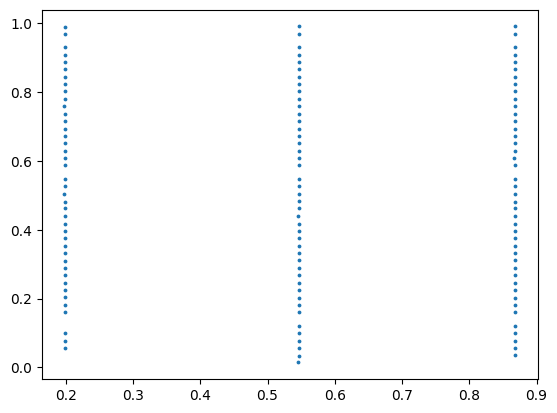

In [449]:
plt.scatter(table.arr_xpos, table.arr_ypos, s = 3)

In [482]:
table.cells

[[{'value': 'Err', 'x_c': 0.19855182926829268, 'y_c': 0.014070752640845063},
  {'value': '2', 'x_c': 0.5458984375, 'y_c': 0.014070752640845063},
  {'value': 'Err', 'x_c': 0.867664425872093, 'y_c': 0.014070752640845063}],
 [{'value': 'Err', 'x_c': 0.19855182926829268, 'y_c': 0.033904599471831},
  {'value': '332674.26', 'x_c': 0.546875, 'y_c': 0.033904599471831},
  {'value': '1473525.44', 'x_c': 0.8671875, 'y_c': 0.03466743973456121}],
 [{'value': '2', 'x_c': 0.19873046875, 'y_c': 0.0560269670910076},
  {'value': '332681.91', 'x_c': 0.54638671875, 'y_c': 0.05602696709100757},
  {'value': '1473531.88', 'x_c': 0.8681640625, 'y_c': 0.05602696709100757}],
 [{'value': '3', 'x_c': 0.1982421875, 'y_c': 0.07738649444745394},
  {'value': '332670.27', 'x_c': 0.54638671875, 'y_c': 0.07738649444745394},
  {'value': '1473546.79', 'x_c': 0.86767578125, 'y_c': 0.07738649444745394}],
 [{'value': '4', 'x_c': 0.1982421875, 'y_c': 0.09950886206663057},
  {'value': '332662.47', 'x_c': 0.54638671875, 'y_c': 

In [555]:
centers = np.array([y_steps.min(), y_steps.max()]).reshape(-1,1)
centers.shape

(2, 1)

/home/reshetnikov/asbest/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

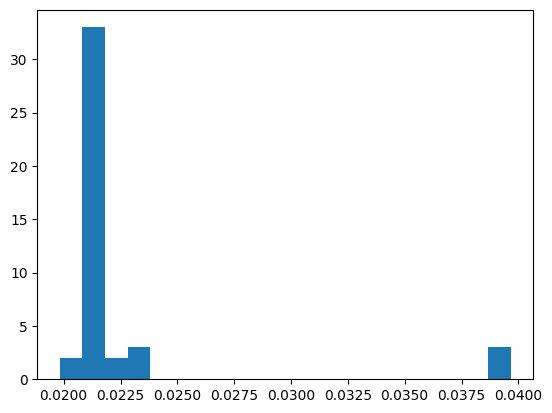

In [568]:
y_pos = np.array([x['y_c'] for x in table.lst_X])
y_steps = y_pos[1:] - y_pos[:-1]
plt.hist(y_steps,20)
kmean = KMeans(2)
kmean.n_clusters
kmean.cluster_centers_ = [0,1]
kmean.fit(y_steps.reshape(-1,1))

number_classter = kmean.predict(y_steps.reshape(-1,1))
number_classter  

In [554]:
y_steps

array([   0.019834,    0.022122,     0.02136,     0.02136,     0.02136,    0.039668,     0.02136,     0.02136,    0.022122,    0.020597,    0.022885,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,    0.022885,     0.02136,     0.02136,     0.02136,     0.02136,
          0.039668,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,    0.022885,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,     0.02136,    0.039668,    0.021148])

In [418]:
ycoords = table.arr_xpos
y_diff = ycoords[1:] - ycoords[:-1]
index = np.where(y_diff > y_diff.mean())[0]
yc_lvl = ycoords[index]

n = len(y_diff)
if n < 3:
    mean_delta = y_diff.mean()
else:
    mean_delta = np.sort(y_diff)[3:].mean()

ymain_lvl = [ycoords[0]]
print(ymain_lvl)
for v in ycoords:
    delta = abs(v - ymain_lvl[-1])
    print(delta, mean_delta)
    if delta < mean_delta * 0.5:
        continue
    else:
        ymain_lvl.append(v)
print(ymain_lvl)

[0.043129697939866374]
0.0 0.025746126331935893
0.0008993509883073458 0.025746126331935893
0.0017987019766147194 0.025746126331935893
0.0008993509883073458 0.025746126331935893
0.0017987019766147194 0.025746126331935893
0.0008993509883073458 0.025746126331935893
0.0008993509883073458 0.025746126331935893
0.09712990673719377 0.025746126331935893
0.09712990673719377 0.025746126331935893
0.0017987019766146917 0.025746126331935893
0.0017987019766146917 0.025746126331935893
0.017987019766147 0.025746126331935893
0.017987019766147 0.025746126331935893
0.09712990673719377 0.025746126331935893
0.0818409399359688 0.025746126331935893
0.0026980529649220375 0.025746126331935893
0.0017987019766146917 0.025746126331935893
0.0026980529649220375 0.025746126331935893
0.0 0.025746126331935893
0.46586381194320703 0.025746126331935893
0.0 0.025746126331935893
0.002698052964922093 0.025746126331935893
0.0 0.025746126331935893
0.0008993509883072903 0.025746126331935893
0.0008993509883074013 0.0257461263319

In [480]:
pd.set_option('display.max_rows',200)

df = pd.read_excel("./results/231031057.xlsx", header=None).iloc[:,:2]
df.head(25)

0           1
0   333376.58  1468566.79
1   333380.41  1468569.32
2   333398.64  1468544.91
3   333401.94  1468543.94
4   333403.44  1468544.35
5   333405.35  1468541.30
6   333384.28  1468526.15
7   333385.82  1468524.44
8   333368.35  1468511.13
9   333362.77  1468506.72
10  333367.16  1468501.12
11  333368.26  1468499.78
12  333359.21  1468492.86
13  333353.12  1468501.50
14  333354.57  1468502.49
15  333350.76  1468507.95
16  333352.15  1468508.93
17  333352.47  1468509.84
18  333352.12  1468511.64
19  333353.62  1468540.01
20  333396.28  1468540.01

In [483]:
has_gap = False

def add_gaps_label(df):
    """
    Добавить метку начала и конца полигона для полигонов внутри одной таблицы
    """
    df["O"] = np.nan
    has_gap = False
    for k, line in df.iterrows():
        if k == 0:
            x_val = line[0]
            y_val = line[1]
            df.iloc[0, 2] = "O"
        else:
            if (x_val == line[0]) and (y_val == line[1]):
                has_gap = True
                df.drop(k, inplace=True)
                print(k, x_val, y_val)
                continue
        if has_gap:
            has_gap = False
            x_val = line[0]
            y_val = line[1]
            print(k)
            df.iloc[k, 2] = "K"
    return df

In [487]:
df.to_dict()

{0: {0: 333376.58,
  1: 333380.41,
  2: 333398.64,
  3: 333401.94,
  4: 333403.44,
  5: 333405.35,
  6: 333384.28,
  7: 333385.82,
  8: 333368.35,
  9: 333362.77,
  10: 333367.16,
  11: 333368.26,
  12: 333359.21,
  13: 333353.12,
  14: 333354.57,
  15: 333350.76,
  16: 333352.15,
  17: 333352.47,
  18: 333352.12,
  19: 333353.62,
  20: 333396.28},
 1: {0: 1468566.79,
  1: 1468569.32,
  2: 1468544.91,
  3: 1468543.94,
  4: 1468544.35,
  5: 1468541.3,
  6: 1468526.15,
  7: 1468524.44,
  8: 1468511.13,
  9: 1468506.72,
  10: 1468501.12,
  11: 1468499.78,
  12: 1468492.86,
  13: 1468501.5,
  14: 1468502.49,
  15: 1468507.95,
  16: 1468508.93,
  17: 1468509.84,
  18: 1468511.64,
  19: 1468540.01,
  20: 1468540.01},
 'O': {0: 'O',
  1: nan,
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: nan,
  7: nan,
  8: nan,
  9: nan,
  10: nan,
  11: nan,
  12: nan,
  13: nan,
  14: nan,
  15: nan,
  16: nan,
  17: nan,
  18: nan,
  19: nan,
  20: nan}}

In [484]:
add_gaps_label(df)

0           1    O
0   333376.58  1468566.79    O
1   333380.41  1468569.32  NaN
2   333398.64  1468544.91  NaN
3   333401.94  1468543.94  NaN
4   333403.44  1468544.35  NaN
5   333405.35  1468541.30  NaN
6   333384.28  1468526.15  NaN
7   333385.82  1468524.44  NaN
8   333368.35  1468511.13  NaN
9   333362.77  1468506.72  NaN
10  333367.16  1468501.12  NaN
11  333368.26  1468499.78  NaN
12  333359.21  1468492.86  NaN
13  333353.12  1468501.50  NaN
14  333354.57  1468502.49  NaN
15  333350.76  1468507.95  NaN
16  333352.15  1468508.93  NaN
17  333352.47  1468509.84  NaN
18  333352.12  1468511.64  NaN
19  333353.62  1468540.01  NaN
20  333396.28  1468540.01  NaN

In [479]:
df.tail(60)

0           1    O
0   333376.58  1468566.79    O
1   333380.41  1468569.52  NaN
2   333398.64  1468544.91  NaN
3   333401.94  1468543.94  NaN
4   333403.44  1468544.35  NaN
5   333405.35  1468541.30  NaN
6   333384.28  1468526.15  NaN
7   333385.82  1468524.44  NaN
8   333368.35  1468511.13  NaN
9   333362.77  1468506.72  NaN
10  333367.16  1468501.12  NaN
11  333368.26  1468499.78  NaN
12  333359.21  1468492.86  NaN
13  333353.12  1468501.50  NaN
14  333354.57  1468502.49  NaN
15  333350.76  1468507.95  NaN
16  333352.15  1468508.93  NaN
17  333352.47  1468509.84  NaN
18  333352.12  1468511.64  NaN
19  333353.62  1468509.55  NaN
20  333396.28  1468540.01  NaN
22   15006.00        0.00  NaN

In [1107]:
help(recognition_predictor)

Help on function recognition_predictor in module doctr.models.recognition.zoo:

recognition_predictor(arch: Any = 'crnn_vgg16_bn', pretrained: bool = False, **kwargs: Any) -> doctr.models.recognition.predictor.pytorch.RecognitionPredictor
    Text recognition architecture.
    
    Example::
        >>> import numpy as np
        >>> from doctr.models import recognition_predictor
        >>> model = recognition_predictor(pretrained=True)
        >>> input_page = (255 * np.random.rand(32, 128, 3)).astype(np.uint8)
        >>> out = model([input_page])
    
    Args:
        arch: name of the architecture or model itself to use (e.g. 'crnn_vgg16_bn')
        pretrained: If True, returns a model pre-trained on our text recognition dataset
    
    Returns:
        Recognition predictor



In [1128]:
from doctr.models import recognition_predictor
predictor = recognition_predictor('crnn_mobilenet_v3_large', pretrained= True)

# checkpoint = torch.load(
#     "./sar_resnet31.pt", map_location="cuda"
# )
# predictor.model.load_state_dict(checkpoint)

In [1177]:
def get_tresh(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # test_img = cv2.morphologyEx(test_img, cv2.MORPH_OPEN, kernel)
    # test_img = cv2.fastNlMeansDenoisingColored(test_img, None, 10, 10, 7, 15)                       
    # test_img = cv2.erode(test_img,kernel = np.ones((2,2), np.uint8))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # thresh1 = cv2.dilate(thresh1, kernel = np.ones((2,2)), iterations=1)
    gray = cv2.erode(thresh1,  kernel = np.ones((1,1), np.uint8))
    h,w = thresh1.shape
    thresh = np.zeros(shape=(h,w,3), dtype = np.uint8)
    thresh[:,:,0] = thresh1
    thresh[:,:,1] = thresh1
    thresh[:,:,2] = thresh1
    return thresh

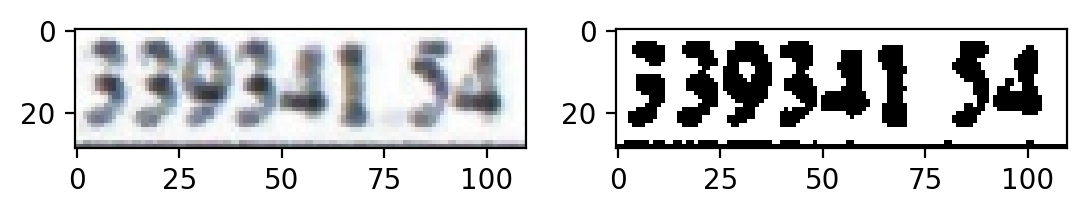

In [1179]:
test_img = cv2.imread('../notebook/results/crop/crop_684_590.jpg')
# test_img = cv2.imread('../notebook/results/crop/crop_1661_1244.jpg')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# test_img = cv2.morphologyEx(test_img, cv2.MORPH_OPEN, kernel)
# test_img = cv2.fastNlMeansDenoisingColored(test_img, None, 10, 10, 7, 15)                       
# test_img = cv2.erode(test_img,kernel = np.ones((2,2), np.uint8))

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# thresh1 = cv2.dilate(thresh1, kernel = np.ones((2,2)), iterations=1)
gray = cv2.erode(thresh1,  kernel = np.ones((1,1), np.uint8))
h,w = thresh1.shape
thresh = np.zeros(shape=(h,w,3), dtype = np.uint8)
thresh[:,:,0] = thresh1
thresh[:,:,1] = thresh1
thresh[:,:,2] = thresh1
fig,ax = plt.subplots(1,2, dpi = 200)
ax[0].imshow(test_img)
ax[1].imshow(thresh)

In [1161]:
# thresh = torch.tensor(thresh, dtype = torch.float).unsqueeze(0).permute(0,3,1,2)
# thresh.shape

In [1162]:
ocr = ocr_predictor(
    reco_arch="crnn_mobilenet_v3_large",
    pretrained=True,
    detect_language=True,
    detect_orientation=False,
)

In [1169]:
ocr.reco_predictor([test_img])

[('1463769,11', 0.9839534759521484)]

In [1178]:
for f in Path("../notebook/results/crop/").glob('*.jpg'):
    test_img = cv2.imread(str(f))
    thresh = get_tresh(test_img)
    r=predictor([test_img])[0][0]
    r2=predictor([thresh])[0][0]
    print(r, r2, f)

1467848,85 147348.85 ../notebook/results/crop/crop_265_46.jpg
338392,66 338392,66 ../notebook/results/crop/crop_130_535.jpg
341035,33 341035,33 ../notebook/results/crop/crop_344_88.jpg
1471164,88 1471164,88 ../notebook/results/crop/crop_238_31.jpg
1471164,62 1471104.62 ../notebook/results/crop/crop_233_67.jpg
7230Ha1 7230Ha1 ../notebook/results/crop/crop_277_629.jpg
341000,66 341000,66 ../notebook/results/crop/crop_345_157.jpg
345152.92 345152.92 ../notebook/results/crop/crop_133_66.jpg
1466455.18 1466455.18 ../notebook/results/crop/crop_271_371.jpg
338050.87 338050.87 ../notebook/results/crop/crop_141_4.jpg
341008,42 341008,42 ../notebook/results/crop/crop_347_17.jpg
335368,58 335308,58 ../notebook/results/crop/crop_113_265.jpg
331414,34 331414,34 ../notebook/results/crop/crop_483_313.jpg
1471180.49 1471180,49 ../notebook/results/crop/crop_234_244.jpg
335384,23 335384,23 ../notebook/results/crop/crop_117_53.jpg
145323044 14432X144 ../notebook/results/crop/crop_234_344.jpg
345151.23 34

In [1148]:
r=predictor([thresh])

[('1463779,81', 0.8866429924964905)]

In [647]:
from sklearn.cluster import KMeans
import numpy as np

cluster_centers = np.array([[0, 10, 5]]).T
kmeans = KMeans(init = cluster_centers, n_clusters=3, n_init=1)
# kmeans = KMeans(init = "k-means++", n_clusters=3, n_init=1)
kmeans = kmeans.fit(data.reshape(-1,1))
print(kmeans.cluster_centers_)

[[       1.25]
 [      10.25]
 [      5.375]]


In [949]:
def letterbox_image(image, expected_size=(736, 736)):
    ih, iw, _ = image.shape
    eh, ew = expected_size
    scale = min(eh / ih, ew / iw)
    nh = int(ih * scale)
    nw = int(iw * scale)

    image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)
    new_img = np.full((eh, ew, 3), 128, dtype="uint8")
    # fill new image with the resized image and centered it
    new_img[
        (eh - nh) // 2 : (eh - nh) // 2 + nh, (ew - nw) // 2 : (ew - nw) // 2 + nw, :
    ] = image.copy()
    pad_h = (eh - nh) // 2 
    pad_w = (ew - nw) // 2
    
    return new_img, nh, nw, pad_h, pad_w, scale

In [936]:
def letterbox_image(image, expected_size=(736, 736)):
    ih, iw, _ = image.shape
    eh, ew = expected_size
    scale = min(eh / ih, ew / iw)
    nh = int(ih * scale)
    nw = int(iw * scale)
    print(ih, iw,scale, nh, nw)
    image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)
    print(image.shape)
    new_img = np.full((eh, ew, 3), 128, dtype="uint8")
    # fill new image with the resized image and centered it
    new_img[
        (eh - nh) // 2 : (eh - nh) // 2 + nh, (ew - nw) // 2 : (ew - nw) // 2 + nw, :
    ] = image.copy()

    print( (eh - nh) // 2 , (eh - nh) // 2 + nh, (ew - nw) // 2 , (ew - nw) // 2 + nw)
    step_h = (eh - nh) // 2 
    step_w = (ew - nw) // 2
    return new_img, nh, nw, step_h, step_w, scale

In [973]:
def letterxyxy2org(x1, y1, x2, y2, h_org, w_org, h_let, w_let, pad_h, pad_w, scale):
    """
    Конверт координаты бокса x1y1x2y2 из lettr изображения в x1y1x2y2 исходного изображения
    """
    print(x1, y1, x2, y2, h_org, w_org, h_let, w_let, pad_h, pad_w, scale)
    xa1 = int(x1 / w_let * w_org - pad_w / scale)
    ya1 = int(y1 / h_let * h_org - pad_h / scale)

    xa2 = int(x2 / w_let * w_org - pad_w / scale)
    ya2 = int(y2 / h_let * h_org - pad_h / scale)
    return xa1, ya1, xa2, ya2


538 512 614 711 2339 1653 736 520 0 108 0.314664386489953


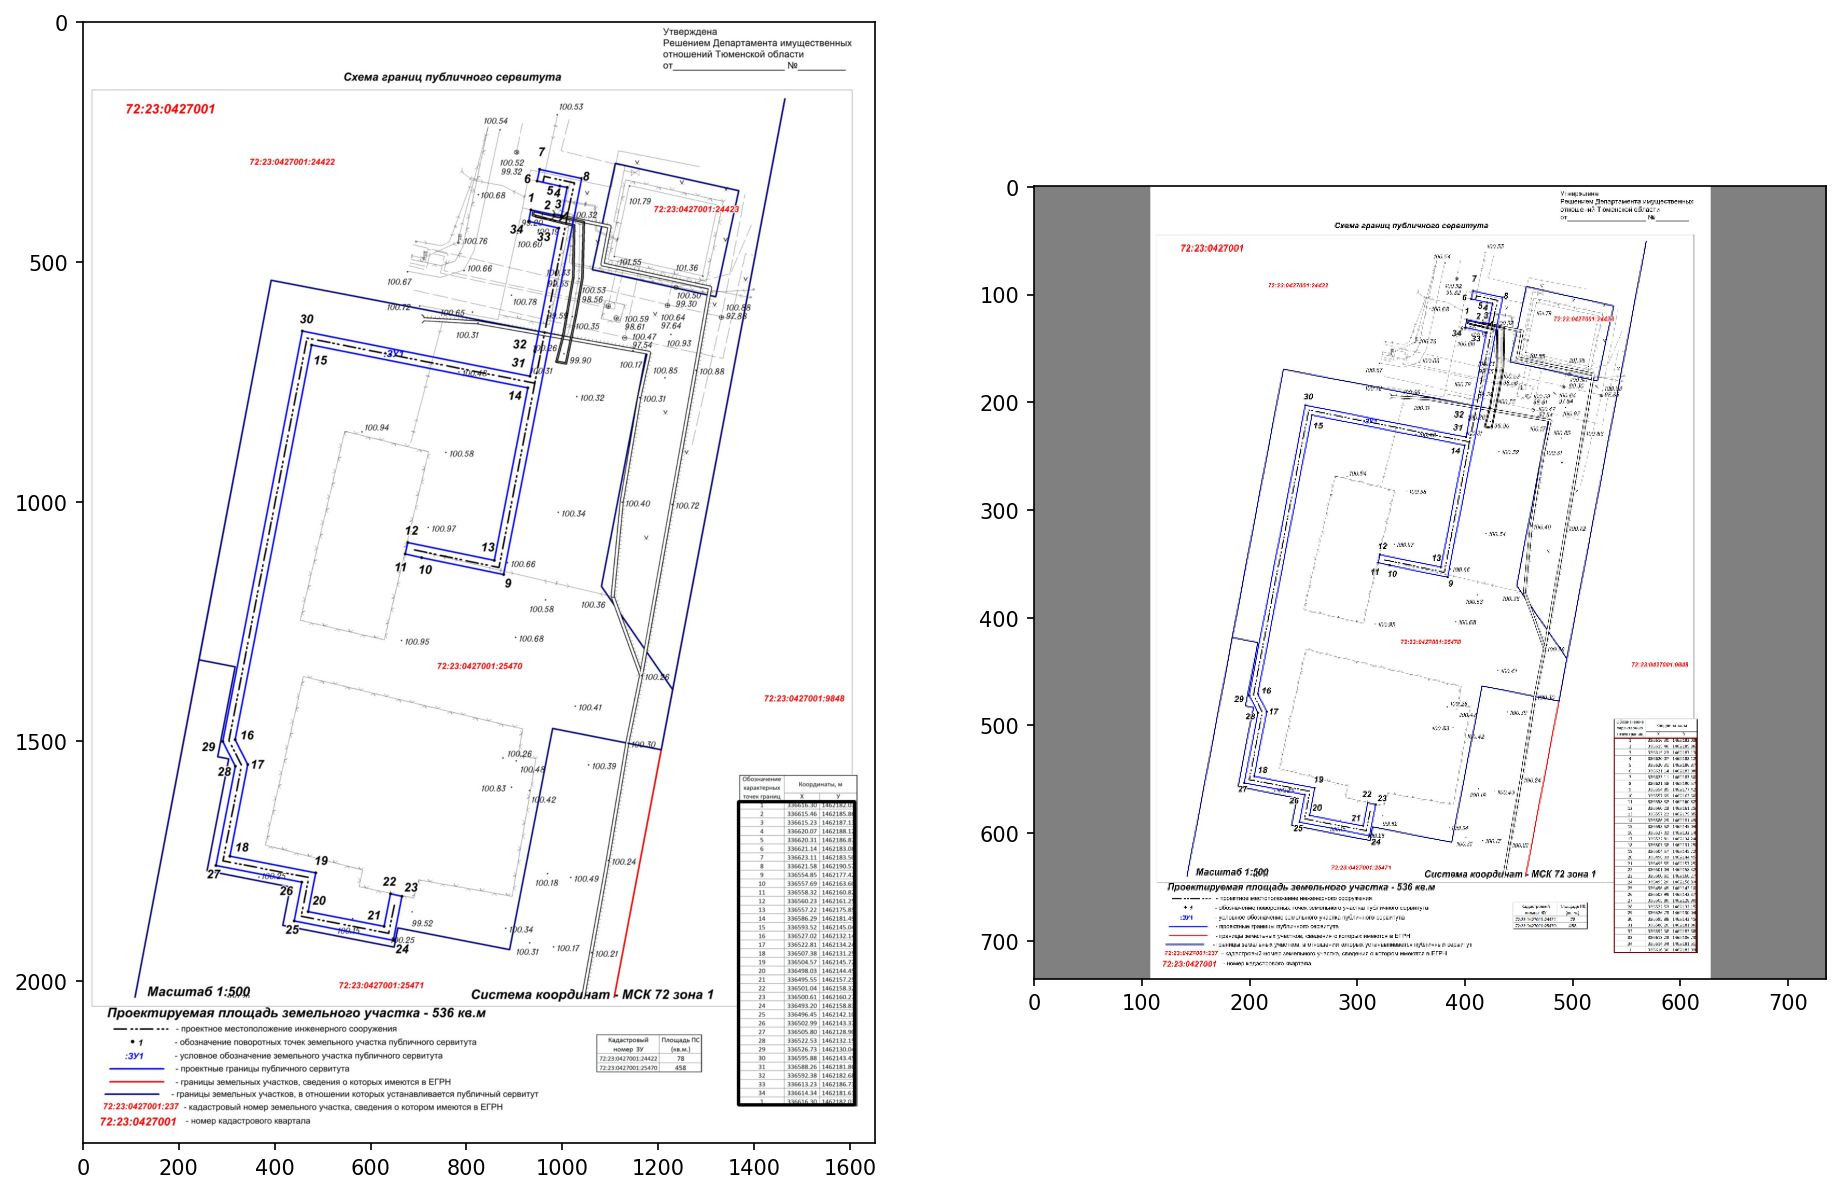

In [975]:
img_source = cv2.imread("../dataset/table_img/1020_page_0.jpg")
h, w, _ = img_source.shape
img, nh, nw, step_h, step_w, scale = letterbox_image(img_source)
xa_1 = 538
ya_1 = 512
xa_2 = 614
ya_2 = 711
xn_1 = xa_1/nw
yn_1 = ya_1/nh
xn_2 = xa_2/nw
yn_2 = ya_2/nh
fig, ax = plt.subplots(1,2,dpi = 150, figsize = (15,12))
img = cv2.rectangle(img, (xa_1, ya_1), (xa_2, ya_2), 121)

a1,b1,a2,b2 = letterxyxy2org(xa_1, ya_1, xa_2, ya_2, h, w, nh, nw, step_h, step_w, scale)
img_source = cv2.rectangle(img_source, (a1, b1) , (a2,b2), 1, 5)
ax[0].imshow(img_source)
ax[1].imshow(img)

In [976]:
a1,b1,a2,b2

(1366, 1627, 1608, 2259)